# Analysis of Top-K Applicant Rankings Using JobBERT

This notebook explores how JobBERT ranks applicants for a collection of job postings and examines representation patterns among the highest-scoring candidates. We load the CV-job similarity scores produced earlier, link them to the job records, and compute a rank for every applicant within each job.

Once the ranking is established, we extract the top candidates at different cutoffs (top-3, top-5, top-7, top-10). These ranked subsets will later help us study whether certain demographic groups appear more frequently at the top of the list. The goal is to identify trends—such as gender or ethnicity dominance—in the most competitive positions for each role.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
OUT_DIR = "similarity_matching_output"

CV_JOB_PATH = os.path.join(OUT_DIR, "cv_job_similarity_minilm_base.csv")
JOB_RECORDS_PATH = "job_records.csv"

In [3]:
cv_job_df = pd.read_csv(CV_JOB_PATH)
job_df = pd.read_csv(JOB_RECORDS_PATH)

## 1. Aggregate top k applicants per job

### a. Helper functions

**Function to Retrieve Top-K Applicants for a Single Job**

This function selects the highest-ranked applicants for a given job based on their similarity scores.
It assumes that the main dataframe already contains a precomputed rank column for each (`job_id`, `cv_id`) pair.

In [4]:
def get_top_k_applicants_for_job(cv_job_ranked: pd.DataFrame,
                                 job_id: str,
                                 k: int = 10) -> pd.DataFrame:
    """
    Return the top-k applicants for a given job_id based on similarity score.
    Assumes cv_job_ranked already has a 'rank' column per job.
    """
    subset = cv_job_ranked[
        (cv_job_ranked["job_id"] == job_id) &
        (cv_job_ranked["rank"] <= k)
    ].copy()
    
    # Optional: enforce sorting by rank
    subset = subset.sort_values("rank")
    return subset

**Function to Retrieve Top-K Applicants for All Jobs**

This function loops over all job postings in the job records and extracts the top-k candidates for each job.
The result is a unified dataframe that contains one row per selected applicant per job.

In [5]:
def get_top_k_for_all_jobs(cv_job_ranked: pd.DataFrame,
                           job_df: pd.DataFrame,
                           k: int = 10) -> pd.DataFrame:
    """
    For every job in job_df, collect the top-k applicants (by similarity).
    Returns a dataframe with one row per (job_id, cv_id) up to rank k.
    """
    # Use only job_ids that exist in the job_records
    job_ids = job_df["job_id"].unique()
    
    top_k_list = []
    for jid in job_ids:
        top_k = get_top_k_applicants_for_job(cv_job_ranked, jid, k=k)
        top_k_list.append(top_k)
    
    if not top_k_list:
        return pd.DataFrame()
    
    all_top_k = pd.concat(top_k_list, ignore_index=True)
    return all_top_k

### b. Ranking All Applicants Per Job

In [6]:
# 1) Compute a rank for every (job, cv) pair, sorted by similarity
cv_job_ranked = (
    cv_job_df
    .sort_values(["job_id", "similarity"], ascending=[True, False])
    .copy()
)

cv_job_ranked["rank"] = (
    cv_job_ranked
    .groupby("job_id")
    .cumcount() + 1  # rank starts at 1
)

### c. Aggregate Top-K and merge job metadata

In [7]:
top10_all_jobs = get_top_k_for_all_jobs(cv_job_ranked, job_df, k=10)

In [8]:
top10_all_jobs = (
    get_top_k_for_all_jobs(cv_job_ranked, job_df, k=10)
    .merge(
        job_df[["job_id", "role", "domain", "level"]],
        on="job_id",
        how="left",
        suffixes=("", "_from_job_records")
    )
)

top10_all_jobs.to_csv(os.path.join(OUT_DIR, "top10_all_jobs_miniLM_base.csv"), index=False)

top10_all_jobs.head()

,cv_id,name,gender,ethnicity,role,job_id,job_role,job_domain,job_level,job_text,similarity,rank,role_from_job_records,domain,level
0,CV_918,Diego Fernández,male,hispanic_latin_american,Software Engineer,JOB_0,Software Engineer,tech,Junior,Hiring a Junior Software Engineer to implement...,0.590048,1,Software Engineer,tech,Junior
1,CV_198,Arjun Menon,male,south_asian,Software Engineer,JOB_0,Software Engineer,tech,Junior,Hiring a Junior Software Engineer to implement...,0.579740,2,Software Engineer,tech,Junior
2,CV_792,James Wilson,male,western_european,Software Engineer,JOB_0,Software Engineer,tech,Junior,Hiring a Junior Software Engineer to implement...,0.569454,3,Software Engineer,tech,Junior
3,CV_810,Emily Johnson,female,western_european,Software Engineer,JOB_0,Software Engineer,tech,Junior,Hiring a Junior Software Engineer to implement...,0.569172,4,Software Engineer,tech,Junior
4,CV_576,Tunde Adebayo,male,african,Software Engineer,JOB_0,Software Engineer,tech,Junior,Hiring a Junior Software Engineer to implement...,0.566559,5,Software Engineer,tech,Junior


---
---

## 2. Representation Analysis Across Multiple Ranking Cutoffs

In this section, we build on the aggregated top-10 candidate list created earlier and examine how demographic representation changes at different ranking depths. Using modular helper functions, we compute gender and ethnicity proportions for several cutoffs (_top-3, top-5, top-7, and top-10_) based on the same underlying dataset.

By comparing these windows, we can observe whether certain demographic groups appear more frequently at the very top, whether representation becomes more balanced as the cutoff expands, or whether specific patterns persist regardless of ranking depth.

In [9]:
path = os.path.join(OUT_DIR, 'top10_all_jobs_miniLM_base.csv')
top10_all_jobs = pd.read_csv(path)

### helper functions

In [10]:
JOBS_COUNT = len(top10_all_jobs['job_id'].unique())

In [11]:
def get_top_k_counts(top10_df, k=3):
    df_k = top10_df[top10_df["rank"] <= k].copy()
    
    gender_counts = df_k.groupby('job_id')['gender'].value_counts().unstack(fill_value=0)
    eth_counts = df_k.groupby('job_id')['ethnicity'].value_counts().unstack(fill_value=0)
    
    counts_per_job = (
        gender_counts.merge(
            eth_counts,
            on='job_id',
            how="left",
        )
    )
    
    return counts_per_job

In [12]:
def get_categorical_ratios(topk_counts, k=3):
    gender_cols = ["female", "male"]
    ethnicity_cols = [c for c in top3_counts.columns if c not in gender_cols + ["job_id"]]
    total_slots = JOBS_COUNT * k

    topk_gender_ratios = pd.Series(
        {
            "female": topk_counts['female'].sum(skipna=True) / total_slots,
            "male": topk_counts['male'].sum(skipna=True) / total_slots,
        }
    )

    ethnicity_ratios = (topk_counts[ethnicity_cols].sum() / total_slots).sort_values(ascending=False)

    return topk_gender_ratios, ethnicity_ratios

### a. TOP 3

In [13]:
top3_counts = get_top_k_counts(top10_all_jobs, k=3)

In [14]:
top3_gender_ratios, top3_ethnicity_ratios = get_categorical_ratios(topk_counts=top3_counts, k=3)

print("Average gender proportions across jobs (top-3):")
print("==============================================")
print(top3_gender_ratios)

print("\n**********************************************\n")

print("Average ethnicity proportions across jobs (top-3):")
print("==============================================")
for eth, ratio in top3_ethnicity_ratios.items():
    print(f"{eth:<25}: {ratio:.3f} ({ratio*100:.1f}%)")

Average gender proportions across jobs (top-3):
female    0.37037
male      0.62963
dtype: float64

**********************************************

Average ethnicity proportions across jobs (top-3):
western_european         : 0.285 (28.5%)
south_asian              : 0.139 (13.9%)
hispanic_latin_american  : 0.132 (13.2%)
southeast_asian          : 0.132 (13.2%)
east_asian               : 0.120 (12.0%)
arabic_middle_eastern    : 0.086 (8.6%)
african                  : 0.074 (7.4%)
eastern_european_slavic  : 0.032 (3.2%)


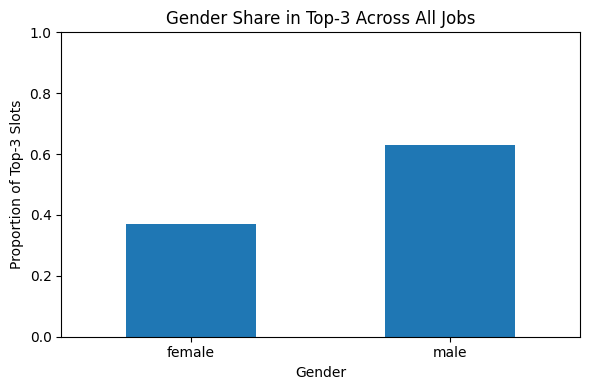

In [15]:
plt.figure(figsize=(6, 4))
top3_gender_ratios.plot(kind="bar")
plt.title("Gender Share in Top-3 Across All Jobs")
plt.ylabel("Proportion of Top-3 Slots")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

---

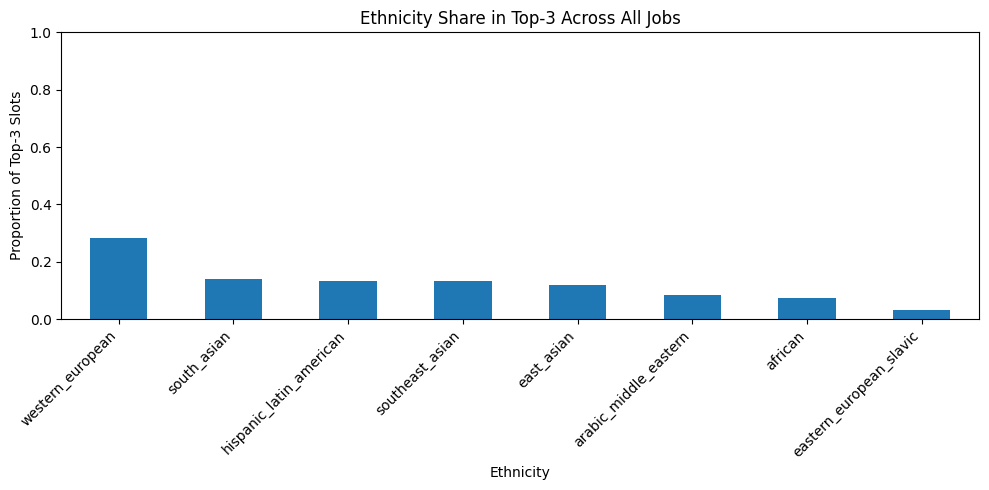

In [16]:
plt.figure(figsize=(10, 5))
top3_ethnicity_ratios.plot(kind="bar")
plt.title("Ethnicity Share in Top-3 Across All Jobs")
plt.ylabel("Proportion of Top-3 Slots")
plt.xlabel("Ethnicity")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

---

### b. TOP 5

In [17]:
top5_counts = get_top_k_counts(top10_all_jobs, k=5)

In [18]:
top5_gender_ratios, top5_ethnicity_ratios = get_categorical_ratios(topk_counts=top5_counts, k=5)

print("Average gender proportions across jobs (top-5):")
print("==============================================")
print(top5_gender_ratios)

print("\n**********************************************\n")

print("Average ethnicity proportions across jobs (top-5):")
print("==============================================")
for eth, ratio in top5_ethnicity_ratios.items():
    print(f"{eth:<25}: {ratio:.3f} ({ratio*100:.1f}%)")

Average gender proportions across jobs (top-5):
female    0.375
male      0.625
dtype: float64

**********************************************

Average ethnicity proportions across jobs (top-5):
western_european         : 0.254 (25.4%)
south_asian              : 0.163 (16.2%)
hispanic_latin_american  : 0.146 (14.6%)
east_asian               : 0.135 (13.5%)
southeast_asian          : 0.117 (11.7%)
african                  : 0.076 (7.6%)
arabic_middle_eastern    : 0.074 (7.4%)
eastern_european_slavic  : 0.036 (3.6%)


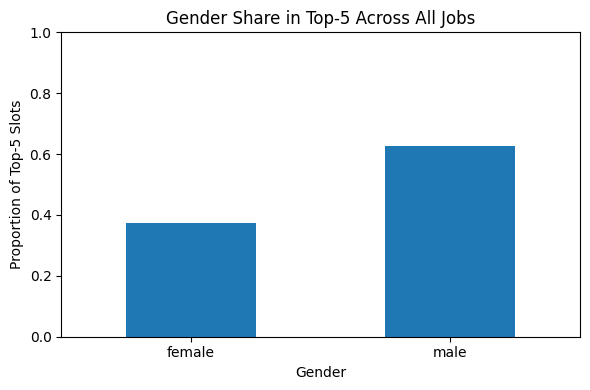

In [19]:
plt.figure(figsize=(6, 4))
top5_gender_ratios.plot(kind="bar")
plt.title("Gender Share in Top-5 Across All Jobs")
plt.ylabel("Proportion of Top-5 Slots")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

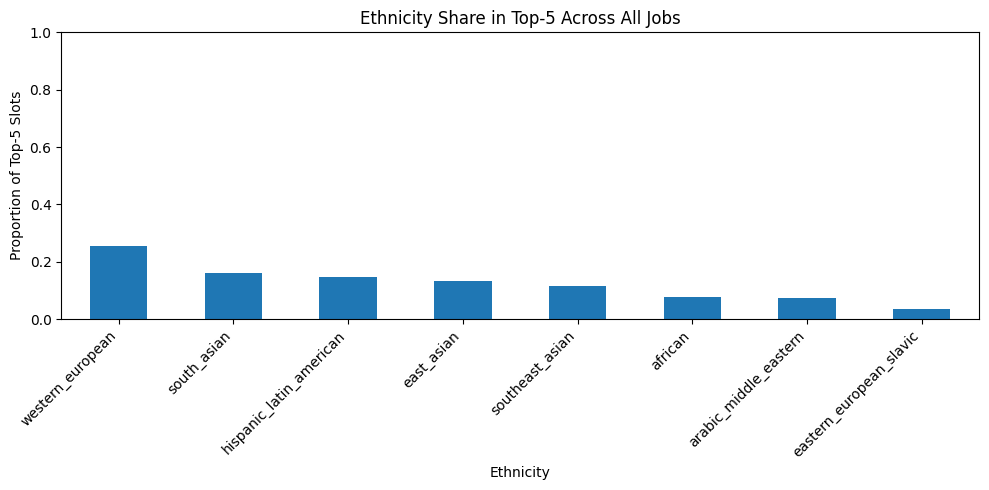

In [20]:
plt.figure(figsize=(10, 5))
top5_ethnicity_ratios.plot(kind="bar")
plt.title("Ethnicity Share in Top-5 Across All Jobs")
plt.ylabel("Proportion of Top-5 Slots")
plt.xlabel("Ethnicity")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

---

### c. TOP 7

In [21]:
top7_counts = get_top_k_counts(top10_all_jobs, k=7)

In [22]:
top7_gender_ratios, top7_ethnicity_ratios = get_categorical_ratios(topk_counts=top7_counts, k=7)

print("Average gender proportions across jobs (top-7):")
print("==============================================")
print(top7_gender_ratios)

print("\n**********************************************\n")

print("Average ethnicity proportions across jobs (top-7):")
print("==============================================")
for eth, ratio in top7_ethnicity_ratios.items():
    print(f"{eth:<25}: {ratio:.3f} ({ratio*100:.1f}%)")

Average gender proportions across jobs (top-7):
female    0.373016
male      0.626984
dtype: float64

**********************************************

Average ethnicity proportions across jobs (top-7):
western_european         : 0.235 (23.5%)
south_asian              : 0.167 (16.7%)
hispanic_latin_american  : 0.152 (15.2%)
east_asian               : 0.128 (12.8%)
southeast_asian          : 0.125 (12.5%)
african                  : 0.079 (7.9%)
arabic_middle_eastern    : 0.072 (7.2%)
eastern_european_slavic  : 0.042 (4.2%)


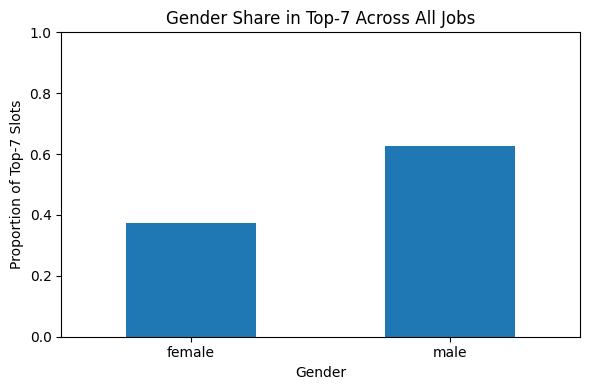

In [23]:
plt.figure(figsize=(6, 4))
top7_gender_ratios.plot(kind="bar")
plt.title("Gender Share in Top-7 Across All Jobs")
plt.ylabel("Proportion of Top-7 Slots")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

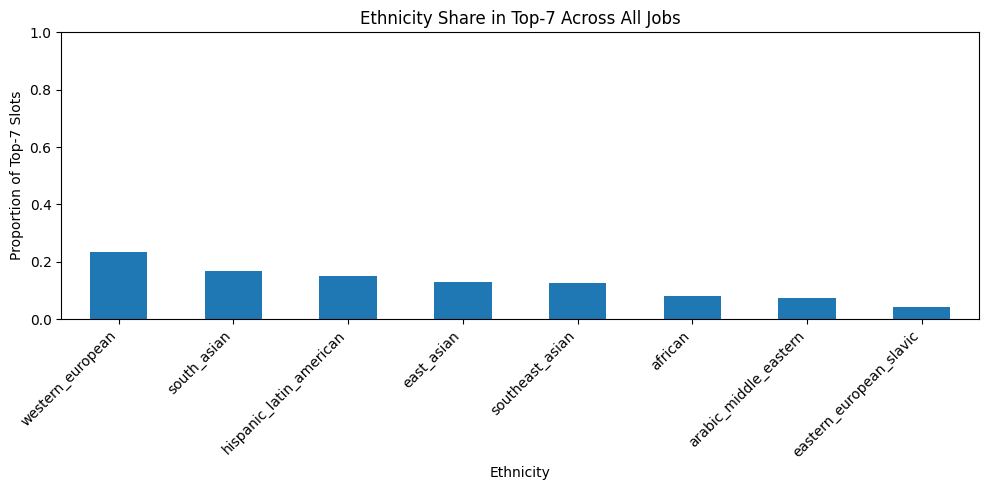

In [24]:
plt.figure(figsize=(10, 5))
top7_ethnicity_ratios.plot(kind="bar")
plt.title("Ethnicity Share in Top-7 Across All Jobs")
plt.ylabel("Proportion of Top-7 Slots")
plt.xlabel("Ethnicity")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

---

### c. TOP 10

In [25]:
top10_counts = get_top_k_counts(top10_all_jobs, k=10)

In [26]:
top10_gender_ratios, top10_ethnicity_ratios = get_categorical_ratios(topk_counts=top10_counts, k=10)

print("Average gender proportions across jobs (top-10):")
print("==============================================")
print(top10_gender_ratios)

print("\n**********************************************\n")

print("Average ethnicity proportions across jobs (top-10):")
print("==============================================")
for eth, ratio in top10_ethnicity_ratios.items():
    print(f"{eth:<25}: {ratio:.3f} ({ratio*100:.1f}%)")

Average gender proportions across jobs (top-10):
female    0.378472
male      0.621528
dtype: float64

**********************************************

Average ethnicity proportions across jobs (top-10):
western_european         : 0.227 (22.7%)
south_asian              : 0.173 (17.3%)
hispanic_latin_american  : 0.149 (14.9%)
southeast_asian          : 0.126 (12.6%)
east_asian               : 0.117 (11.7%)
african                  : 0.089 (8.9%)
arabic_middle_eastern    : 0.075 (7.5%)
eastern_european_slavic  : 0.044 (4.4%)


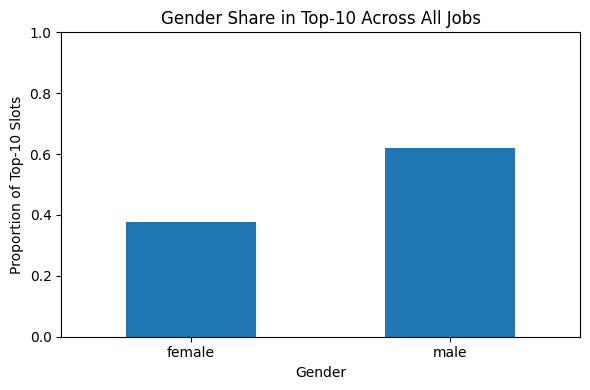

In [27]:
plt.figure(figsize=(6, 4))
top10_gender_ratios.plot(kind="bar")
plt.title("Gender Share in Top-10 Across All Jobs")
plt.ylabel("Proportion of Top-10 Slots")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

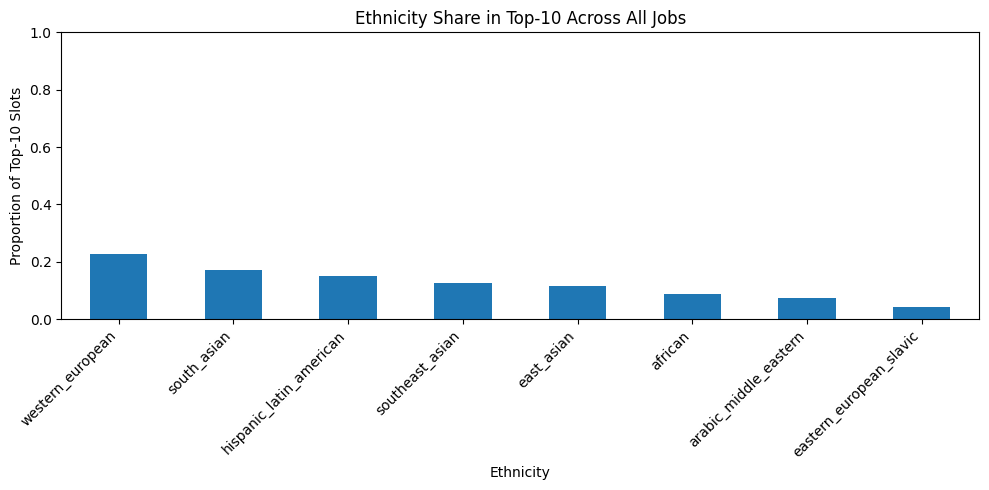

In [28]:
plt.figure(figsize=(10, 5))
top10_ethnicity_ratios.plot(kind="bar")
plt.title("Ethnicity Share in Top-10 Across All Jobs")
plt.ylabel("Proportion of Top-10 Slots")
plt.xlabel("Ethnicity")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()